In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import squidpy as sq
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns

/its/home/am2702/.conda/envs/squidpy_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/its/home/am2702/.conda/envs/squidpy_env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
# Define the main working directory for both input datasets and output files (e.g., plots, tables, spatial maps).

path = '/its/home/am2702/Final pipeline/'

In [3]:
# Read the h5ad data after Scimap.

sq_data = sc.read(path + 'GBM(stardist)/' + 'after_scimap.h5ad')

In [4]:
# Assign spatial coordinates to .obsm.
# Squidpy expects spatial coordinates in a NumPy array of shape (n_cells, 2)
sq_data.obsm['spatial'] = sq_data.obs[['X_centroid', 'Y_centroid']].to_numpy()

# Initialise the required structure in .uns['spatial'] to enable Squidpy plotting.
# Even without an image, this placeholder allows functions like `spatial_scatter` to run.
# If an image becomes available later, it can be added to the 'images' dictionary.
sq_data.uns['spatial'] = {
    'test_tissue1': {
        'images': {}
    }
}

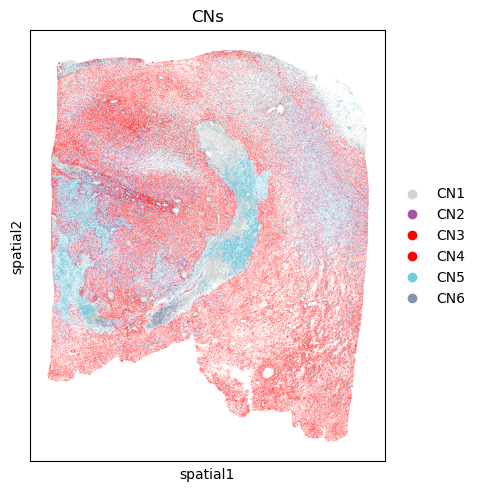

In [7]:
# Convert 'CNs' column to categorical, required for consistent color mapping.
sq_data.obs['CNs'] = sq_data.obs['CNs'].astype('category')

# Define custom colours for each Cell Neighbourhood (CN), based on predominant cell-type composition (or use other approach).

CNs_colors = {
    'CN1': '#D3D3D3',  # Mostly Unknown
    'CN2': '#A356A3',  # Stem-like/Tumour cell-dominant with some Astrocytes
    'CN3': '#FF0000',  # Stem-like/Tumour cell-dominant
    'CN4': '#FF0000',  # Stem-like/Tumour cell-dominant
    'CN5': '#6ECDE0',  # Astrocytes-dominant
    'CN6': '#8492AD',  # Mixed/uncertain 
}

# Squidpy looks for colours in '.uns' using the format '<column_name>_colors'.
# This ensures the CNs will be plotted using the custom colours defined above.
sq_data.uns['CNs_colors'] = [CNs_colors[cat] for cat in sq_data.obs['CNs'].cat.categories]

# Plot CNs spatially using Squidpy. Image is omitted (img=False), and each CN is coloured accordingly.
sq.pl.spatial_scatter(
    sq_data,
    color='CNs',
    connectivity_key= None,
    img=False,
    img_res_key= None,
    size = 6,
    save = path + 'GBM(stardist)/' + 'squidpy_CNs.png'
)

In [ ]:
# Spatially map annotated cell phenotypes using Squidpy’s scatterplot function.
# This map can be overlaid on other tissue images, such as H&E-stained slides, for visual comparison.

# Convert 'cell type' column to categorical format, this ensures consistent colour mapping across plots.
sq_data.obs['cell_type'] = sq_data.obs['cell type'].astype('category')

# Define custom colours for each phenotype based on biomarker positivity profiles or clustering (requires manual assignment)
cell_type_colors = {
    'Naive T cells': '#73D14D',                           # Green
    'Astrocytes': '#4FE0D7',                              # Blue
    'Macrophages/monocytes': '#F59A45',                   # Orange
    'Stem-like/Tumour cells (Olig2⁺)': '#F5D245',         # Yellow
    'Stem-like/Tumour cells (SOX2⁺)': '#F54A45',          # Red
    'Stem-like/Tumour cells (Olig2⁺, SOX2⁺)': '#FF6EA1',  # Pink
    'DAPI⁺ Unknown Cell': '#D3D3D3'                       # Light Gray
}

# Squidpy looks for colours in '.uns' using the format '<column_name>_colors'.
# This links the 'cell_type' column to its corresponding colour scheme.
sq_data.uns['cell_type_colors'] = [cell_type_colors[cat] for cat in sq_data.obs['cell_type'].cat.categories]

# Generate spatial plot of single-cell phenotypes.
sq.pl.spatial_scatter(
    sq_data,
    color='cell_type',
    title= 'Single-Cell Phenotyping Map',
    img=False,
    img_res_key= None,
    legend_fontsize = 'small',
    legend_loc = 'right margin',
    size = 7,
    axis_label = ['', '']#,
    #save = path + 'squidpy_saptial_phenotyping_map.png'
)

In [8]:
# Build a spatial neighbor graph using Delaunay triangulation based on centroid coordinates.
# This is required for downstream spatial analyses (e.g., interaction scores, graph-based clustering).
sq.gr.spatial_neighbors(sq_data, coord_type='generic', delaunay=True)


In [10]:
# Install required packages for Leiden clustering using the igraph backend.
# Note: This is only necessary in environments (e.g., Google Colab or fresh virtual environments) where igraph and leidenalg are not pre-installed.

!pip install igraph leidenalg

  Using cached igraph-0.11.9-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
  Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached texttable-1.7.0-py2.py3-none-any.whl.metadata (9.8 kB)
Using cached igraph-0.11.9-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.4 MB)
Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.0 MB)
Using cached texttable-1.7.0-py2.py3-none-any.whl (10 kB)
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/opt/jupyter-py39/lib/python3.9/site-packages/texttable.py'
Check the permissions.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/3 [texttable]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [19]:
# Perform Leiden clustering using the spatial neighbor graph created by Squidpy (based on Delaunay triangulation).
# This groups spatially close cells with similar neighbourhoods.
# 'adjacency' must point to the graph key created by sq.gr.spatial_neighbors().
# Set 'directed=False' to treat the graph as undirected (which is typical in spatial context).

sc.tl.leiden(
    sq_data,
    flavor='igraph',             # Use igraph backend for performance
    n_iterations=2,
    directed=False,
    resolution=0.03,              # Higher values produce more clusters
    key_added='leiden_delaunay',
    adjacency=sq_data.obsp['spatial_connectivities']  # Uses Squidpy-generated spatial graph
)


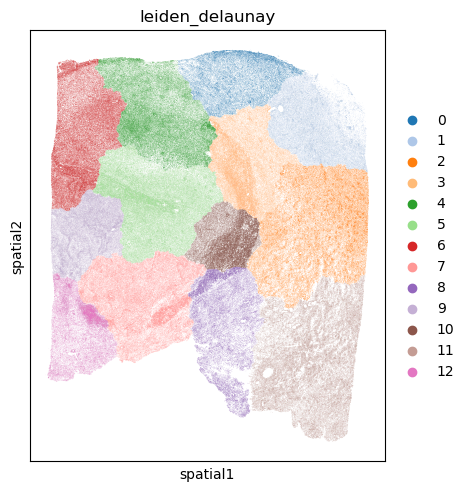

In [4]:
# Remove default Leiden colors if present to avoid conflicts with custom palette.
# Then assign a consistent color palette (tab20) to ensure visually distinct cluster colors.
sq_data.uns.pop('leiden_delaunay_colors', None)


from matplotlib.colors import to_hex

n_clusters = sq_data.obs['leiden_delaunay'].nunique() # Determine number of Leiden clusters and assign a distinct colour to each.
palette = sns.color_palette('tab20', n_colors=n_clusters) # Use seaborn's tab20 palette (or other)
sq_data.uns['leiden_delaunay_colors'] = [to_hex(c) for c in palette] # Convert RGB to hex (Squidpy expects this format)

# Plot the spatial scatter of clusters without background image or graph edges.
sq.pl.spatial_scatter(
    sq_data,
    color='leiden_delaunay',
    connectivity_key=None,
    img = False,
    size = 6 ,
    save = path + 'GBM(stardist)/' + 'CN_deluanya_leiden(0.03).png'
)